In [3]:
import os
import re
import matplotlib.pyplot as plt


In [4]:
import os
import re


def extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE):
    protein_sequences = []        
    missing_file_folders = []    
    protein_not_found_folders = {}  # Dicion√°rio para armazenar pastas e motivos
    discarded_by_size = {}  
    tamanhos_sequencias = []     
    
    gene_pattern = re.compile(r'\[gene=([^\]]+)\]', re.IGNORECASE)
    
    exact_match = re.compile(rf'\b{protein_name}\b', re.IGNORECASE)
    term_exclusion = re.compile(r'\b(truncated|fragment)\b', re.IGNORECASE)

    for folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder)
        if not os.path.isdir(folder_path):
            continue
            
        file_path = os.path.join(folder_path, "cds_from_genomic.fna")
        if not os.path.exists(file_path):
            missing_file_folders.append(folder)
            continue
            
        found = False  
        current_header = None
        current_sequence = []
        
        # Vari√°veis para rastrear motivos
        has_correct_gene = False
        has_excluded_terms = False
        
        with open(file_path, "r") as file:
            for line in file:
                line = line.strip()
                
                if line.startswith(">"):
                    if current_header:
                        gene_data = gene_pattern.search(current_header)
                        
                        gene = (gene_data.group(1).lower() if gene_data else "")
                        
                        valid_gene_current = (gene == protein_name.lower())
                        header_clean_current = not term_exclusion.search(current_header.lower())
                        
                        # Atualiza os motivos
                        if valid_gene_current:
                            has_correct_gene = True
                            if not header_clean_current:
                                has_excluded_terms = True

                        seq_length = len(''.join(current_sequence))
                        
                        if valid_gene_current and header_clean_current:
                            if MIN_SIZE <= seq_length <= MAX_SIZE:
                                new_header = f"{current_header} tamanho: {seq_length}"
                                protein_sequences.append(f"{new_header}\n{''.join(current_sequence)}")
                                tamanhos_sequencias.append(seq_length)
                                found = True
                            else:
                                discarded_by_size[folder] = current_header

                    current_header = line
                    current_sequence = []
                else:
                    current_sequence.append(line)
            
            if current_header:
                gene_data = gene_pattern.search(current_header)
                
                gene = (gene_data.group(1).lower() if gene_data else "")
                
                valid_gene_current = (gene == protein_name.lower())
                header_clean_current = not term_exclusion.search(current_header.lower())
                
                # Atualiza os motivos
                if valid_gene_current:
                    has_correct_gene = True
                    if not valid_gene_current:
                        print(f"   Gene inv√°lido no arquivo {file_path}: {current_header}")  # Imprime o cabe√ßalho que causou o erro
                    if not header_clean_current:
                        has_excluded_terms = True
                        print(f"   Termos proibidos no arquivo {file_path}: {current_header}")  # Imprime o cabe√ßalho que causou o erro

                seq_length = len(''.join(current_sequence))
                
                if valid_gene_current and header_clean_current:
                    if MIN_SIZE <= seq_length <= MAX_SIZE:
                        new_header = f"{current_header} tamanho: {seq_length}"
                        protein_sequences.append(f"{new_header}\n{''.join(current_sequence)}")
                        tamanhos_sequencias.append(seq_length)
                        found = True
                    else:
                        discarded_by_size[folder] = current_header
        
        # Determina os motivos ap√≥s processar todos os cabe√ßalhos
        if not found and folder not in discarded_by_size:
            reasons = []
            if not has_correct_gene:
                reasons.append(f"N√£o h√° {protein_name}")
            if has_excluded_terms:
                reasons.append("Termos proibidos no cabe√ßalho")
            if reasons:
                protein_not_found_folders[folder] = reasons

    if protein_sequences:
        with open(output_file, "w") as fasta_file:
            fasta_file.write("\n".join(protein_sequences) + "\n")
        print(f"‚úÖ Arquivo {output_file} gerado com {len(protein_sequences)} sequ√™ncias.")

    print("\n=== DIAGN√ìSTICO ===")
    print(f"Total de tamanhos armazenados: {len(tamanhos_sequencias)}")
    print(f"Pastas sem arquivo: {len(missing_file_folders)}")
    print(f"Pastas com arquivo inv√°lido: {len(protein_not_found_folders)}")
    print(f"Pastas com sequ√™ncias descartadas por tamanho inadequado: {len(discarded_by_size)}")
    print(f"Total problem√°tico: {len(missing_file_folders) + len(protein_not_found_folders) + len(discarded_by_size)}\n")
    
    if missing_file_folders:
        print("üîç Pastas sem arquivo:") 
        for folder in missing_file_folders:
            print(f"   - {folder}")
    
    if protein_not_found_folders:
        print("\nüîç Pastas com arquivo inv√°lido:")  
        for folder, reasons in protein_not_found_folders.items():
            print(f"   - {folder}: {', '.join(reasons)}")

    if discarded_by_size:
        print("\nüîç Pastas com sequ√™ncias descartadas por tamanho inadequado:")
        print(f"   (Crit√©rio: tamanho aceit√°vel entre {MIN_SIZE} e {MAX_SIZE} nucleot√≠deos)")
        for folder, header in discarded_by_size.items():
            print(f"   - {folder}: {header}")

    return tamanhos_sequencias

In [5]:
def plot(tamanhos_sequencias, protein_name): 
    # Dados de exemplo (substitua pela sua lista de tamanhos_sequencias)
    # tamanhos_sequencias = [1500, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

    # Criar lista de √≠ndices para o eixo X
    indices = range(len(tamanhos_sequencias))

    # Criar gr√°fico de dispers√£o
    plt.figure(figsize=(10, 5))  # Define o tamanho da figura
    plt.scatter(indices, tamanhos_sequencias, color='blue', alpha=0.7)  # Plota os pontos

    # Configura√ß√µes do gr√°fico
    plt.xlabel("√çndice da Sequ√™ncia", fontsize=12)  # R√≥tulo do eixo X
    plt.ylabel("Tamanho da Sequ√™ncia (nucleot√≠deos)", fontsize=12)  # R√≥tulo do eixo Y
    plt.title(f"Tamanho das Sequ√™ncias do {protein_name}", fontsize=14, fontweight='bold')  # T√≠tulo
    plt.grid(linestyle='--', alpha=0.7)  # Adiciona grid

    # Exibir gr√°fico
    plt.show()
    # Dados de exemplo (substitua pela sua lista de tamanhos_sequencias)
    # tamanhos_sequencias = [1500, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

    # Criar histograma
    plt.figure(figsize=(10, 5))  # Define o tamanho da figura
    plt.hist(tamanhos_sequencias, bins=20, edgecolor='black', color='skyblue')  # Plota o histograma

    # Configura√ß√µes do gr√°fico
    plt.xlabel("Tamanho da sequ√™ncia (nucleot√≠deos)", fontsize=12)  # R√≥tulo do eixo X
    plt.ylabel("Frequ√™ncia", fontsize=12)  # R√≥tulo do eixo Y
    plt.title(f"Distribui√ß√£o do Tamanho do {protein_name}", fontsize=14, fontweight='bold')  # T√≠tulo
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adiciona grid no eixo Y

    # Exibir gr√°fico
    plt.show()

PARA O GAG

‚úÖ Arquivo gag.fasta gerado com 422 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 422
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 46
Pastas com sequ√™ncias descartadas por tamanho inadequado: 6
Total problem√°tico: 78

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

üîç Pastas com arquivo inv√°lido:
   - GCA_003097955.1: Termos proibidos no cabe√ßalho
   - GCA_003098355.1: N√£o h√° Gag
   - GCA_003098655.1: N√£o h√° Gag
   - GCA_003098935.1:

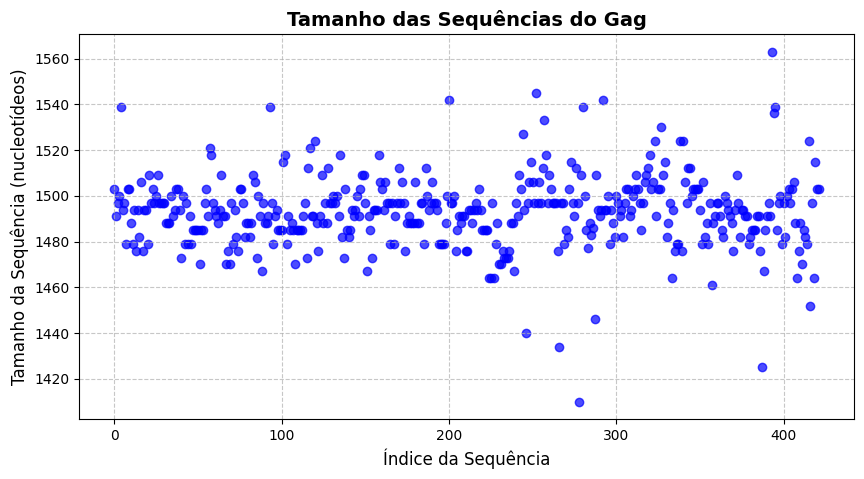

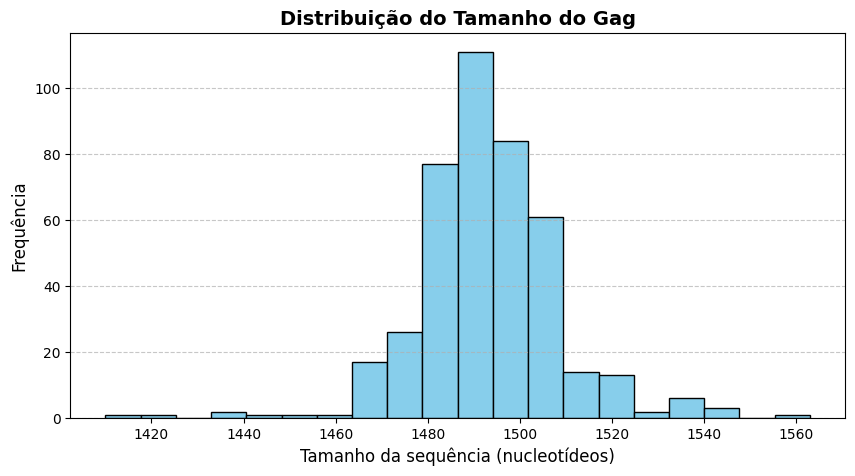

In [7]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "Gag"
output_file = "gag.fasta"
MIN_SIZE = 1400
MAX_SIZE = 1600

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)

PARA POL

‚úÖ Arquivo pol.fasta gerado com 369 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 369
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 65
Pastas com sequ√™ncias descartadas por tamanho inadequado: 40
Total problem√°tico: 131

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

üîç Pastas com arquivo inv√°lido:
   - GCA_003097875.1: N√£o h√° Pol
   - GCA_003097895.1: N√£o h√° Pol
   - GCA_003097915.1: N√£o h√° Pol
   - GCA_003098015.1: N√£o h√° Pol
  

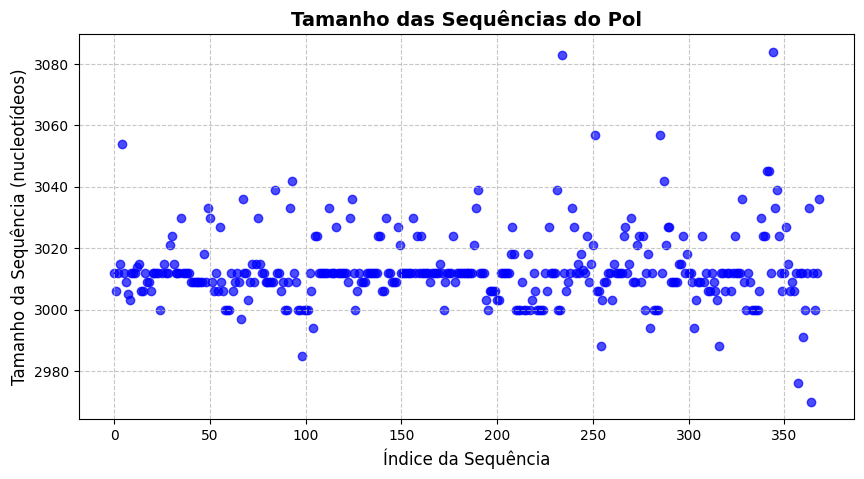

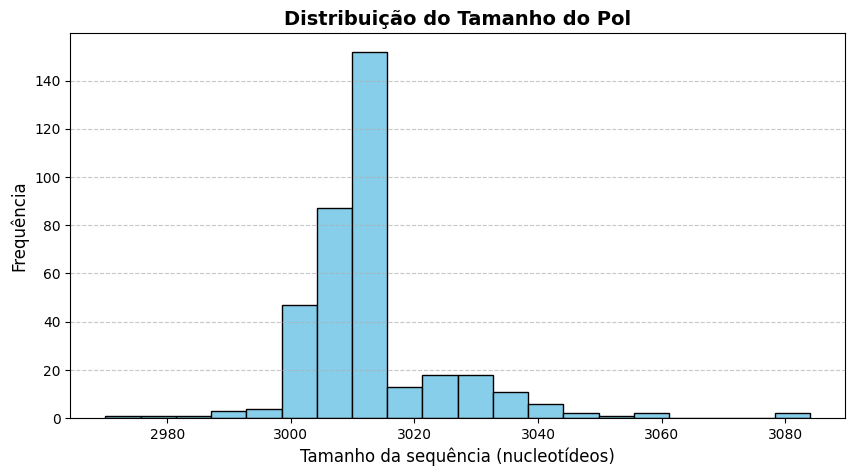

In [12]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "Pol"
output_file = "pol.fasta"
MIN_SIZE = 2950 
MAX_SIZE = 3100

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)


‚úÖ Arquivo env.fasta gerado com 426 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 426
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 42
Pastas com sequ√™ncias descartadas por tamanho inadequado: 6
Total problem√°tico: 74

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

üîç Pastas com arquivo inv√°lido:
   - GCA_003097935.1: Termos proibidos no cabe√ßalho
   - GCA_003097975.1: N√£o h√° env
   - GCA_003098435.1: Termos proibidos no cabe√ßalho
   

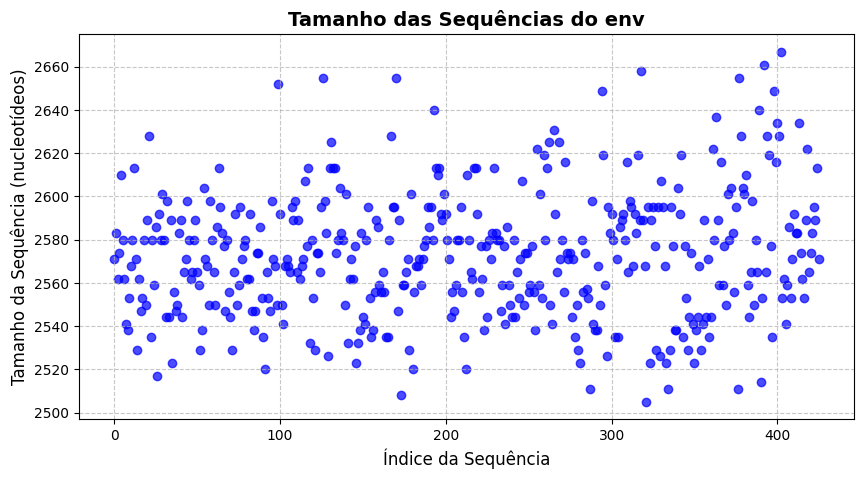

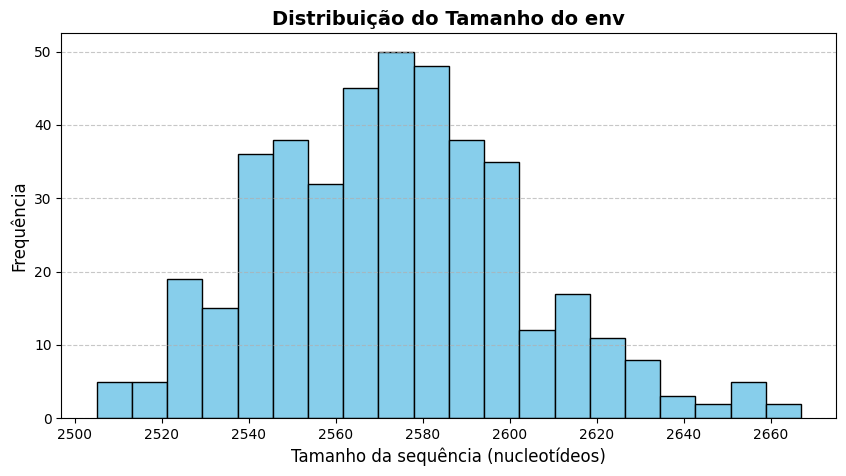

In [13]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "env"
output_file = "env.fasta"
MIN_SIZE = 2500 
MAX_SIZE = 2700

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)

‚úÖ Arquivo Gag-Pol.fasta gerado com 11 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 11
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 463
Pastas com sequ√™ncias descartadas por tamanho inadequado: 0
Total problem√°tico: 489

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

üîç Pastas com arquivo inv√°lido:
   - GCA_000864765.1: N√£o h√° gag-pol
   - GCA_003097775.1: N√£o h√° gag-pol
   - GCA_003097795.1: N√£o h√° gag-pol
   - GCA_003097815.1: N

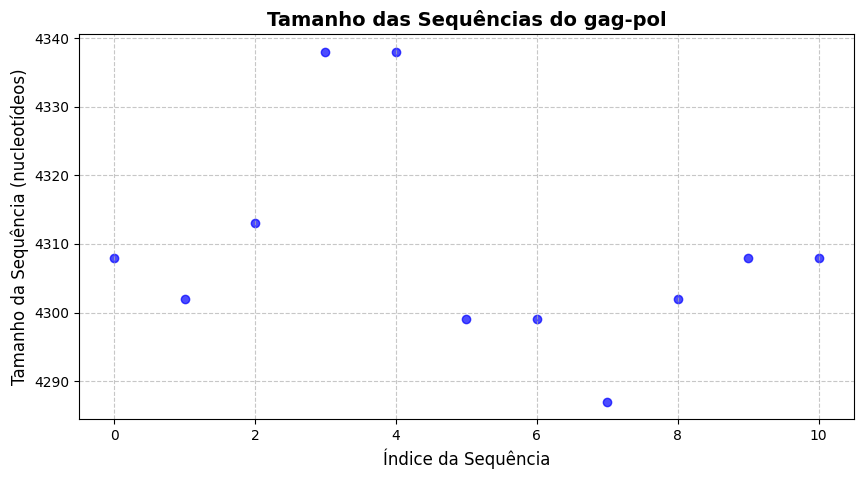

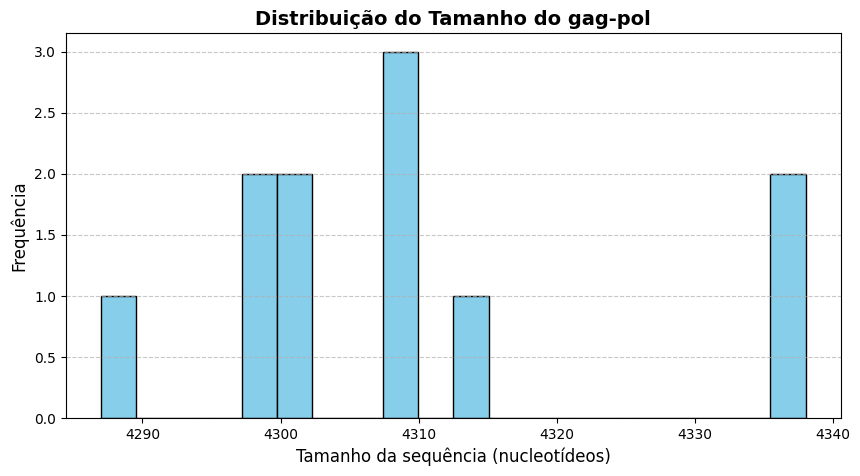

In [14]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "gag-pol"
output_file = "Gag-Pol.fasta"
MIN_SIZE = 0 
MAX_SIZE = 5000

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)

‚úÖ Arquivo Tat.fasta gerado com 374 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 374
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 69
Pastas com sequ√™ncias descartadas por tamanho inadequado: 31
Total problem√°tico: 126

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

üîç Pastas com arquivo inv√°lido:
   - GCA_003097875.1: N√£o h√° Tat
   - GCA_003098375.1: Termos proibidos no cabe√ßalho
   - GCA_003098675.1: N√£o h√° Tat
   - GCA_003098695.

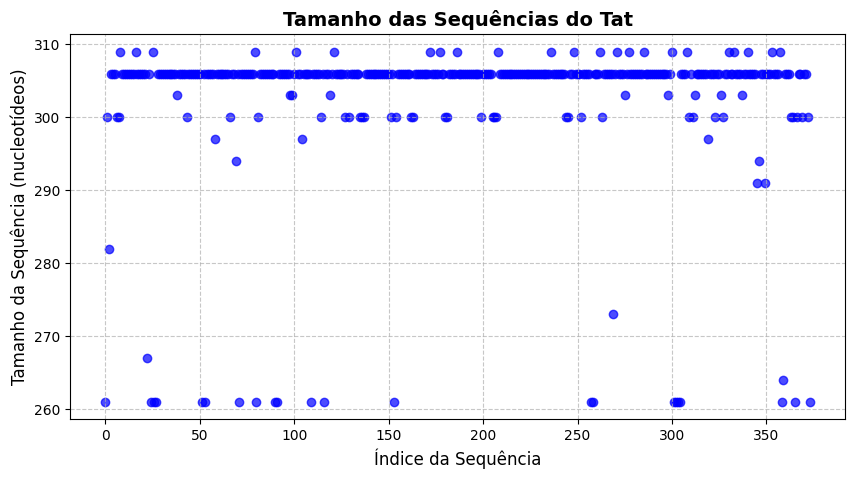

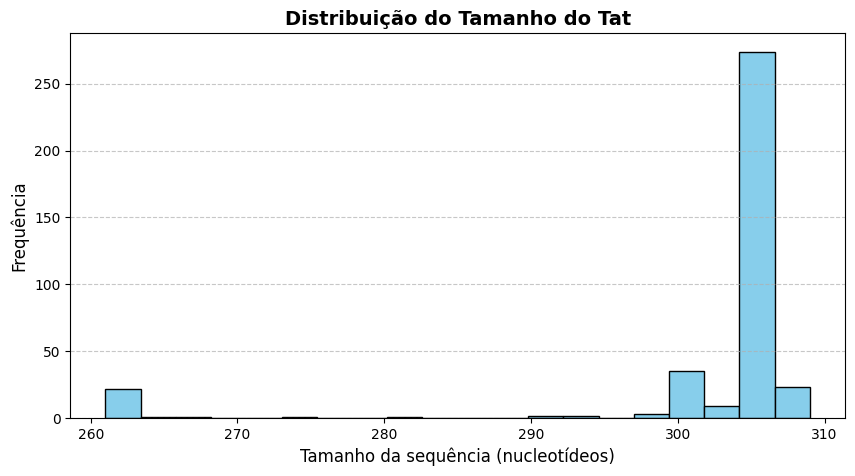

In [15]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "Tat"
output_file = "Tat.fasta"
MIN_SIZE = 260
MAX_SIZE = 310

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)

   Termos proibidos no arquivo data\GCA_003101115.1\cds_from_genomic.fna: >lcl|EF091932.1_cds_ABL68023.1_6 [gene=rev] [protein=truncated rev protein] [protein_id=ABL68023.1] [location=join(5403..5478,7872..8098)] [gbkey=CDS]
‚úÖ Arquivo rev.fasta gerado com 387 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 387
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 64
Pastas com sequ√™ncias descartadas por tamanho inadequado: 23
Total problem√°tico: 113

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_0031907

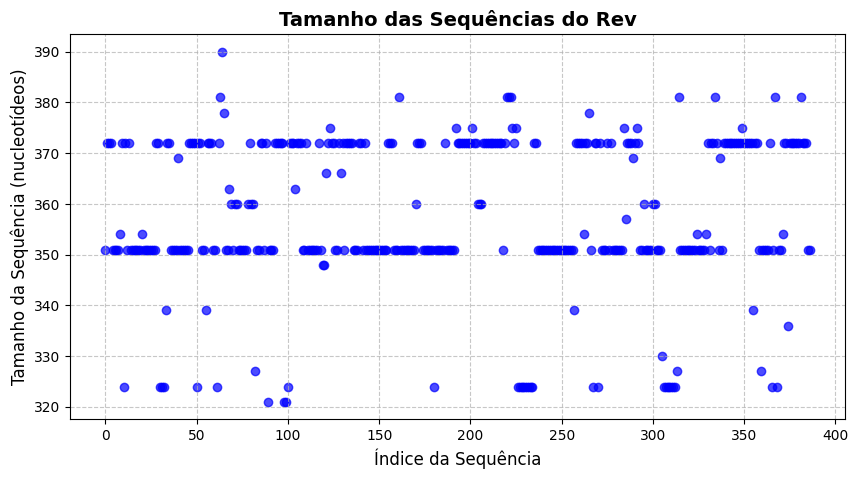

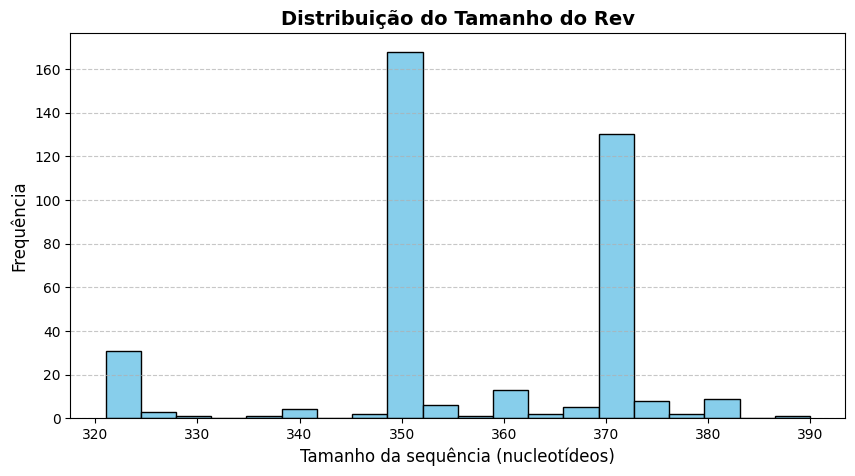

In [16]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "Rev"
output_file = "rev.fasta"
MIN_SIZE = 320
MAX_SIZE = 390

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)

   Termos proibidos no arquivo data\GCA_003100095.1\cds_from_genomic.fna: >lcl|AY536235.1_cds_AAT11227.1_9 [gene=nef] [protein=truncated nef protein] [protein_id=AAT11227.1] [location=8238..8855] [gbkey=CDS]
‚úÖ Arquivo nef.fasta gerado com 381 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 381
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 28
Pastas com sequ√™ncias descartadas por tamanho inadequado: 65
Total problem√°tico: 119

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003

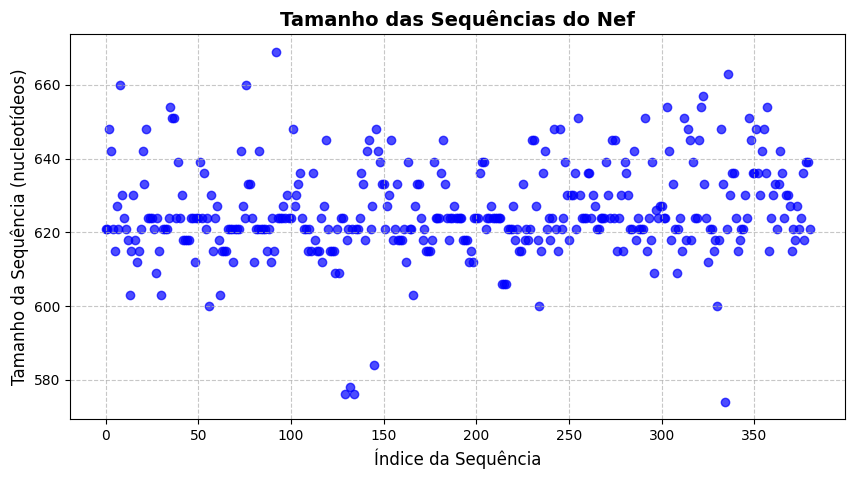

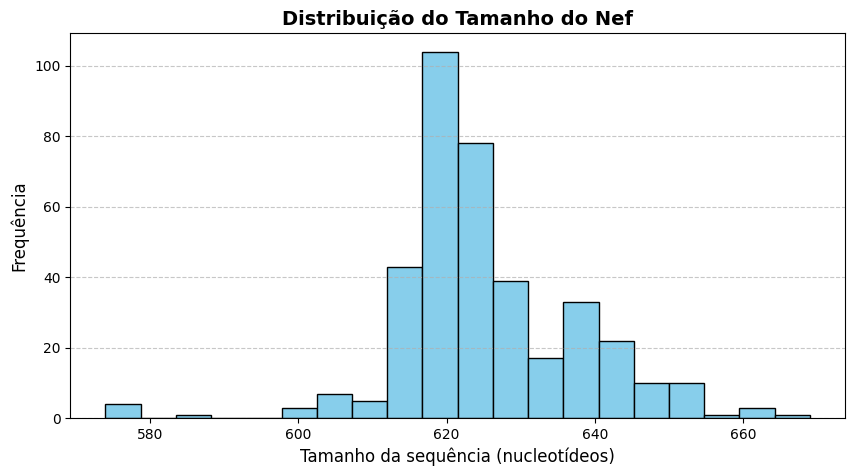

In [17]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "Nef"
output_file = "nef.fasta"
MIN_SIZE = 570
MAX_SIZE = 670

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)

‚úÖ Arquivo vif.fasta gerado com 448 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 448
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 25
Pastas com sequ√™ncias descartadas por tamanho inadequado: 1
Total problem√°tico: 52

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

üîç Pastas com arquivo inv√°lido:
   - GCA_003097875.1: N√£o h√° Vif
   - GCA_003097935.1: Termos proibidos no cabe√ßalho
   - GCA_003098935.1: N√£o h√° Vif
   - GCA_003099135.1:

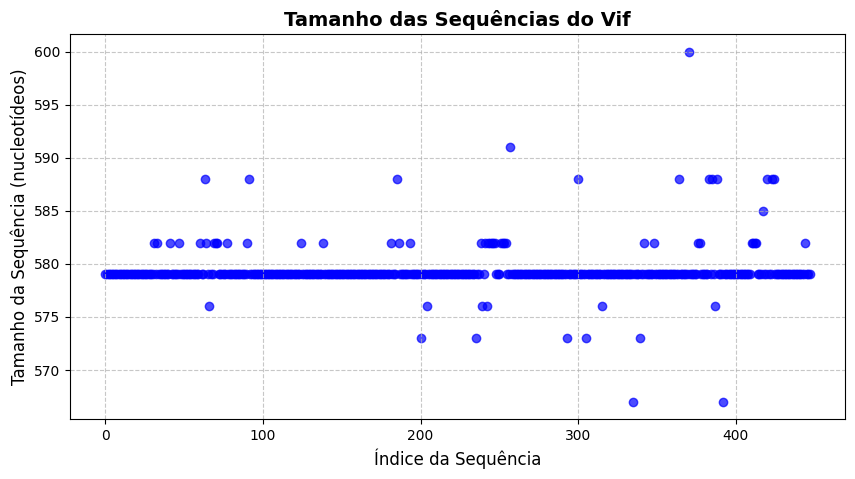

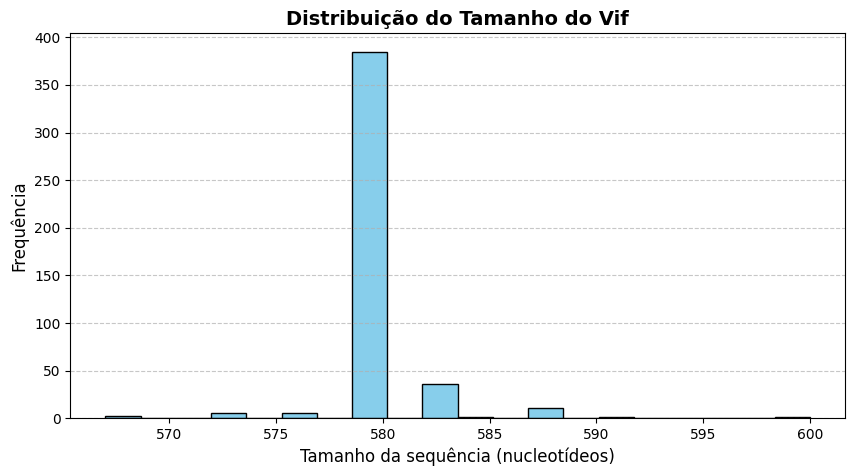

In [18]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "Vif"
output_file = "vif.fasta"
MIN_SIZE = 550
MAX_SIZE = 600

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)

‚úÖ Arquivo vpr.fasta gerado com 439 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 439
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 30
Pastas com sequ√™ncias descartadas por tamanho inadequado: 5
Total problem√°tico: 61

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

üîç Pastas com arquivo inv√°lido:
   - GCA_003097875.1: N√£o h√° Vpr
   - GCA_003098395.1: Termos proibidos no cabe√ßalho
   - GCA_003098495.1: Termos proibidos no cabe√ßalho
   

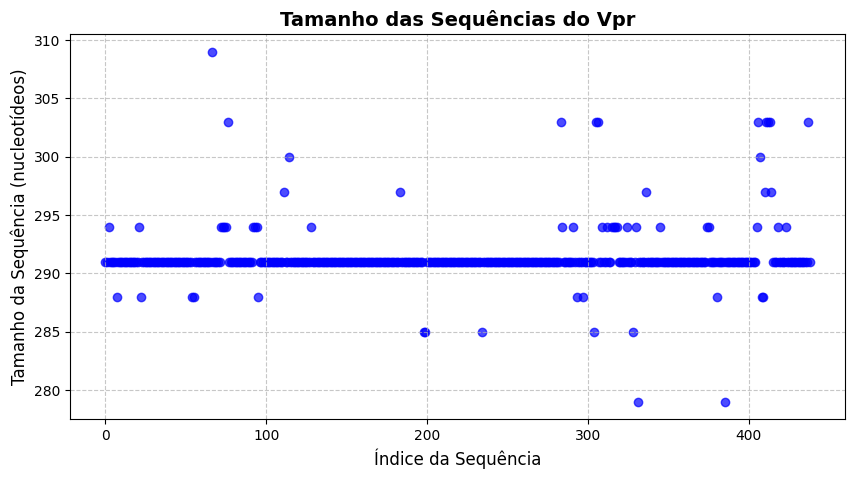

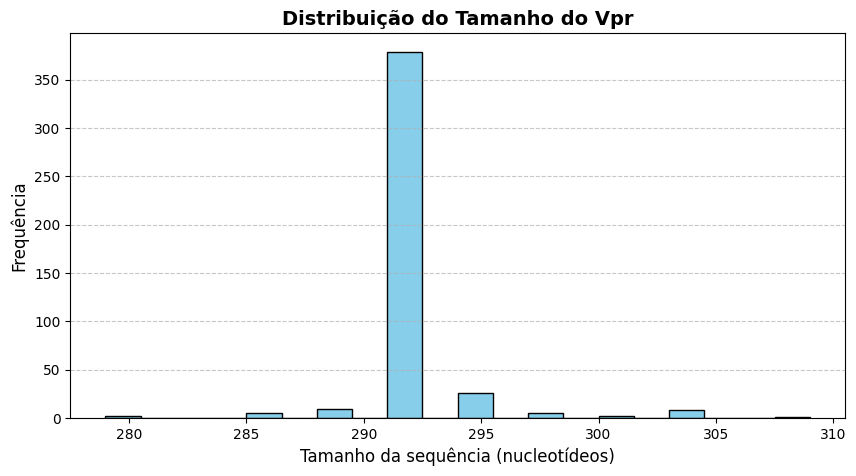

In [19]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "Vpr"
output_file = "vpr.fasta"
MIN_SIZE = 270
MAX_SIZE = 310

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)

‚úÖ Arquivo vpu.fasta gerado com 400 sequ√™ncias.

=== DIAGN√ìSTICO ===
Total de tamanhos armazenados: 400
Pastas sem arquivo: 26
Pastas com arquivo inv√°lido: 49
Pastas com sequ√™ncias descartadas por tamanho inadequado: 26
Total problem√°tico: 101

üîç Pastas sem arquivo:
   - GCA_003098195.1
   - GCA_003099895.1
   - GCA_003100195.1
   - GCA_003100215.1
   - GCA_003102955.1
   - GCA_003102975.1
   - GCA_003104215.1
   - GCA_003104515.1
   - GCA_003104535.1
   - GCA_003188275.1
   - GCA_003188525.1
   - GCA_003188725.1
   - GCA_003189185.1
   - GCA_003189225.1
   - GCA_003189335.1
   - GCA_003189555.1
   - GCA_003189645.1
   - GCA_003189665.1
   - GCA_003189725.1
   - GCA_003190285.1
   - GCA_003190565.1
   - GCA_003190585.1
   - GCA_003190705.1
   - GCA_003190785.1
   - GCA_003855735.1
   - GCA_003856155.1

üîç Pastas com arquivo inv√°lido:
   - GCA_003097875.1: N√£o h√° Vpu
   - GCA_003098355.1: N√£o h√° Vpu
   - GCA_003098375.1: Termos proibidos no cabe√ßalho
   - GCA_003098475.

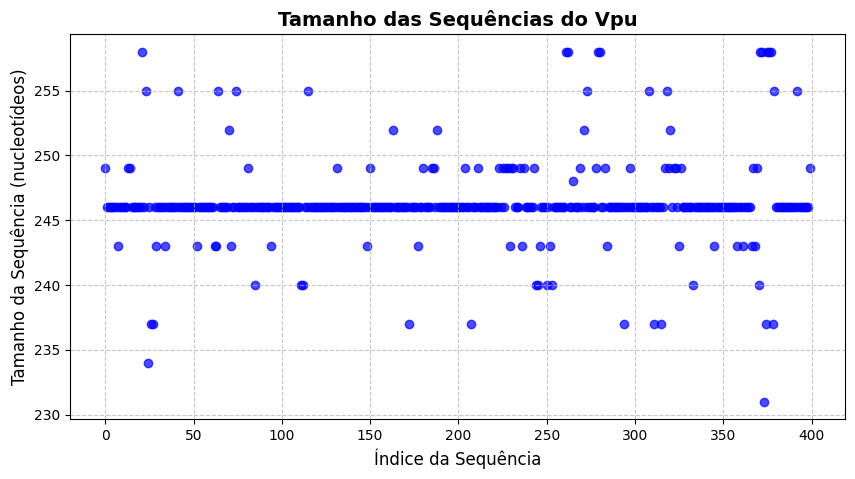

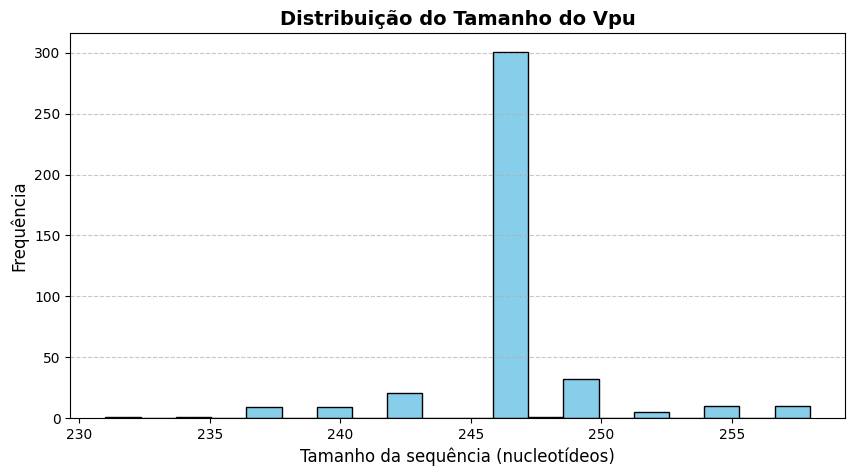

In [20]:
# Configura√ß√£o direta
root_folder = "data"
protein_name = "Vpu"
output_file = "vpu.fasta"
MIN_SIZE = 230
MAX_SIZE = 260

tamanhos_sequencias = extract_protein_sequences(root_folder, protein_name, output_file, MIN_SIZE, MAX_SIZE)
plot(tamanhos_sequencias,protein_name)